<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br></center></h1>

# Student Information

**Name**: Baran Deniz Korkmaz

**ID**: 2015400183

**Department**: Computer Engineering

# Imported Packages
This section introduces the imported packages, as they are the initial requirements for the implementation.

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import math

# Auxiliary Resources
This section contains the auxiliary functions that we utilize for the implementation.

# 1. Data Handling Resources
This section introduces the auxiliary functions that we use to carry out data manipulations.

## a.form_data(X,Y):
Description: Appends the column vector of Y into 2D X-matrix with respect to y-axis.

Parameters:
1. X: 2D Matrix
2. Y: 1D Vector

Return Values: 
1. result: 2D Matrix in form [X,Y].

In [2]:
def form_data(X,Y):
    X,Y = np.array(X),np.array(Y)
    Y = Y.reshape(len(Y), 1)
    return np.hstack((X, Y))

## b.split_data(DATA):
Description: Reverts the effect of form_data function defined above.

Parameters:
1. DATA: 2D Matrix

Return Values: 
1. X: 2D Matrix without the rightmost column vector of DATA.
2. Y: The rightmost column vector of DATA.

In [3]:
def split_data(DATA):
    DATA = np.array(DATA)
    x,y = list(),list()
    for row in DATA:
        x.append(row[:-1])
        y.append(row[-1])
    return np.array(x),np.array(y)

## c.feature_unique_values(X):
Description: Returns a dictionary where key values are the indices of column vectors, and the values are set of unique values within the column vector. The dictionary will later be used in splitting the nodes by all possible threshold values of corrresponding attributes.

Parameters:
1. X: 2D Matrix (Training Data)

Return Values: 
1. dict: Dictionary

In [4]:
def feature_unique_values(X):
    dict = {}
    for (i,row) in enumerate(X):
        cur = []
        for elem in row:
            if elem not in cur:
                cur.append(elem)
        cur.sort()
        dict[i] = cur
    return dict

## d.feature_index(FEATURE_NAMES):
Description: Returns a dictionary where key values feature names and values are their corresponding indices in the transpose of training data. Notice that the transpose of training data will be in a form where its dimension is (number of features)x(number of samples). Therefore this dictionary will guide us through finding the index for corresponding feature in the transpose matrix. This will later be used in plotting and finding the unique values for a given feature.

Parameters:
1. FEATURE_NAMES: The list of feature names provided by Boston data set.

Return Values: 
1. dict: Dictionary

In [5]:
def feature_index(FEATURE_NAMES):
    dict = {}
    for (i,elem) in enumerate(FEATURE_NAMES):
        dict[elem] = i
    return dict

# 2. Plotting Resources
This section introduces the auxiliary functions that we use for plotting.

## a.plot_rss_v_threshold(rss_values,threshold_values,index,feature_labels):
Description: Plots the rss versus threshold values for a given attribute.

Parameters:
1. rss_values: List of rss values for corresponding threshold values.
2. threshold_values: List of threshold values.
3. feature_labels: The list of feature labels.

In [6]:
def plot_rss_v_threshold(rss_values,threshold_values,index,feature_labels):
    fig = plt.figure()
    ax = plt.scatter(threshold_values, rss_values)
    plt.xlabel("Threshold")
    plt.ylabel("RSS")
    plt.title("Rss vs Threshold Value for Feature {}".format(feature_labels[index]))
    plt.show()

## b.autolabel(rects,ax):
Description: Writes the y-values on top of each bar.

Parameters:
1. rects: Bars within the plot.
2. ax: Plot.

Reference:
https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

In [7]:
def autolabel(rects,ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## c.cross_validation_plot(depths,r2_scores,std_devs):
Description: Plots the bar chart and table for reporting the cross validation results.

Parameters:
1. depths: List of depth levels.
2. r2_scores: List of average r-squared values for corresponding depth levels.
3. std_devs: List of standard deviaton of r-squared values for corresponding depth levels.

In [8]:
def cross_validation_plot(depths,r2_scores,std_devs):
    #Rounding
    r2_scores = [round(elem, 5) for elem in r2_scores]
    std_devs = [round(elem, 5) for elem in std_devs]
    x = np.arange(len(depths))
    width = 0.2
    fig, ax = plt.subplots(2)
    plt.suptitle("Cross Validation: Mean and Std Dev of R-Squared vs Depth")
    rects1 = ax[0].bar(x - width / 2, r2_scores, width, label='Mean')
    rects2 = ax[0].bar(x + width / 2, std_devs, width, label='Std Dev')
    ax[0].set_ylabel('Mean and Std Dev of R-Squared')
    ax[0].set_xlabel('Depth')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(depths)
    ax[0].legend(loc='lower right')
    autolabel(rects1, ax[0])
    autolabel(rects2, ax[0])
    data = list()
    data.append(depths)
    data.append(r2_scores)
    data.append(std_devs)
    rowlabel = ("Depth", "Mean", "Std Dev")
    ax[1].axis('tight')
    ax[1].axis('off')
    table = ax[1].table(cellText=data, rowLabels=rowlabel, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    fig.tight_layout()
    plt.show()

## d.r2_plots(r2_training,r2_test,depths):
Description: Plots the bar chart of r-squared values of class predictions for training and test data for corresponding depth levels.

Parameters:
1. r2_training: List of r-squared values for corresponding depth levels of class predictions for training data.
2. r2_test: List of r-squared values for corresponding depth levels of class predictions for test data.
3. depths: List of depth levels.

In [9]:
def r2_plots(r2_training,r2_test,depth):
    #Rounding
    r2_score_training = [round(elem, 5) for elem in r2_training]
    r2_score_test = [round(elem, 5) for elem in r2_test]
    x = np.arange(len(r2_training))  # the label locations
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, r2_score_training, width, label='Training')
    rects2 = ax.bar(x + width / 2, r2_score_test, width, label='Test')
    if len(depth)==1:
        ax.set_title('R-Squared Values (Depth={})'.format(depth[0]))
    else:
        ax.set_title('R-Squared vs Depth')
    ax.set_ylabel('R-Squared Score')
    ax.set_xlabel('Depth')
    ax.set_xticks(x)
    ax.set_xticklabels(depth)
    ax.legend(loc='lower right')
    autolabel(rects1, ax)
    autolabel(rects2, ax)
    fig.tight_layout()
    plt.show()

# 3. Decision Tree Resources
This section introduces the auxiliary functions that we use for the construction of decision tree.

## a.rss(y_left,y_right)::
Description: Returns the rss value of a given splitted class values.

Parameters:
1. y_left: Left split.
2. y_right: Right split.

Return Values:
1. rss: Residual sum of squares.

In [10]:
def rss(y_left,y_right):
    avg_left, avg_right = np.average(y_left),np.average(y_right)
    rss = 0.0
    for elem_left in y_left:
        rss += math.pow(elem_left-avg_left,2)
    for elem_right in y_right:
        rss += math.pow(elem_right-avg_right,2)
    return rss

## b.split_feature_by_threshold(index,value,data_set):
Description: Splits the given data set by an feature based on a value of threshold.

Parameters:
1. index: Index value of feature.
2. value: Threshold value.
3. data_set: 2D Matrix

Implementation Details: For each data sample, if the feature value is less than or equal to a threshold value it will be appended into the left subset, otherwise into the right subset.

Return Values:
1. left: Matrix for left subset.
2. right: Matrix for right subset.

In [11]:
def split_feature_by_threshold(index,value,data_set):
    left,right = [],[]
    for row in data_set:
        if row[index] <= value:
            left.append(row)
        else:
            right.append(row)
    return np.array(left),np.array(right)

## c.find_split_by_feature(index,data_set,enable_plot=False,feature_labels=None):
Description: Finds the best split for a given feature for the data set.

Parameters:
1. index: Index value of feature (feature).
2. data_set: 2D Matrix
3. enable_plot: Parameter for reporting the rss vs threshold levels for a given feature. (By default=False)
4. feature_labels: The list of feature labels (used in plotting). (By default=None)

Implementation Details: For a given feature, the algorithm finds the best threshold and returns the required data for splitting the decision tree. If enable_plot is set to True, then the function plots the rss values for each possible threshold values for the feature.

Return Values:
1. b_threshold: Best threshold.
2. b_rss: Best rss.
3. b_left: Left subset when best threshold is used to split.
4. b_right: Right subset when best threshold is used to split.

In [12]:
def find_split_by_feature(index,data_set,enable_plot=False,feature_labels=None):
    b_threshold, b_rss, b_left, b_right = 0.0, float('inf'), None, None
    xTrain, yTrain = split_data(data_set)
    xTrain_T = np.transpose(xTrain)
    threshold_candidates = feature_unique_values(xTrain_T)[index]
    rss_values = []
    thresholds = []
    for threshold in threshold_candidates:
        left,right = split_feature_by_threshold(index,threshold,data_set)
        _,left_y = split_data(left)
        _,right_y = split_data(right)
        if len(left_y)==0 or len(right_y)==0:
            continue
        current_rss = rss(left_y,right_y)
        thresholds.append(threshold)
        rss_values.append(current_rss)
        if current_rss < b_rss:
            b_threshold , b_rss , b_left , b_right = threshold, current_rss, left, right
    if enable_plot==True:
        plot_rss_v_threshold(rss_values,thresholds,index,feature_labels)
    return b_threshold, b_rss, b_left, b_right

## d.split_node(data_set):
Description: Splits the data set by finding the best feature by utilizing the auxiliary function describe above in (c).

Parameters:
1. data_set: 2D Matrix

Implementation Details: For each feature in data set, the split_node function calls the function described in (c) and returns the final version of splitted node as dictionary. 

The dictionary holds the fields required for the node. These fields are described below:
1. feature: The feature that the node is split by.
2. threshold: The threshold value for the attribute.
3. rss: The rss value for the best split.
4. left: The left subset for the best split. (Data of left child)
5. right: The right subset for the best split. (Data of right child)

Return Values:
1. dictionary: The dictionary that holds the fields of node that is split. The fields are described above.

In [13]:
def split_node(data_set):
    b_feature, b_threshold, b_rss, b_left , b_right =0, 0.0, float('inf'), None, None
    data_set = np.array(data_set)
    for i in range(data_set.shape[1]-1):
        cur_threshold, cur_rss,cur_left,cur_right = find_split_by_feature(i,data_set)
        if cur_rss < b_rss:
            b_feature, b_threshold, b_rss, b_left, b_right = i, cur_threshold, cur_rss, cur_left, cur_right
    #print("Best split for current data set: feature: {}, Threshold: {}, RSS: {:.10}".format(b_feature,b_threshold,b_rss))
    return {'feature': b_feature,'threshold': b_threshold,'rss': b_rss,'left': b_left,'right': b_right}

## e.set_leaf(data):
Description: Returns the value of a node that will be set as a leaf in the decision tree.

Parameters:
1. data: 2D Matrix

Return Values:
1. value: The average of class values.

In [14]:
def set_leaf(data):
    x,y = split_data(data)
    return sum(y)/len(y)

## f.split_tree(node, min_size, max_depth, current_depth):
Description: Recursively splits the tree until max_depth or min_size for a given node is reached. min_size implies the number of data sample the node consists of. In the project, the min_size is set as 1 in function calls.

Parameters:
1. node: The dictionary that represents the node.
2. min_size: Minimum number of samples that a node can have.
3. max_depth: Maximum depth a node can reside.
4. current_depth: Current depth level of a node.

In [15]:
def split_tree(node, min_size, max_depth, current_depth):
    left_data = node['left']
    right_data = node['right']
    if current_depth==max_depth:
        node['left'] = set_leaf(left_data)
        node['right'] = set_leaf(right_data)
        return
    #left child
    if len(node['left']) <= min_size:
        node['left'] = set_leaf(left_data)
    else:
        node['left'] = split_node(left_data)
        split_tree(node['left'],min_size,max_depth,current_depth+1)
    #right child
    if len(node['right']) <= min_size:
        node['right'] = set_leaf(right_data)
    else:
        node['right'] = split_node(right_data)
        split_tree(node['right'],min_size,max_depth,current_depth+1)

## g.train_tree(training_data,min_size, max_depth):
Description: Initiates the recursive split_tree (f) calls by constructing the root first.

Parameters:
1. training_data: 2D Matrix of Training Data (Data of Root)
2. min_size: Minimum number of samples that a node can have.
3. max_depth: Maximum depth a node can reside.

In [16]:
def train_tree(training_data,min_size, max_depth):
    root = split_node(training_data)
    split_tree(root,min_size,max_depth,1)
    return root

## h.cross_validation(data,s,depths):
Description: Operates s-fold cross validation separately for the depth levels given in the list 'depths'.

Parameters:
1. data: 2D Matrix of Training Data
2. s: Cross validation parameter for the number of folds.
3. depths: List of depth levels.

Implementation Details: Since we have a noisy data set, the cross validation function does not shuffle the data one more time by itself in order to avoid from any inconsistent r-squared scores in evaluation section. 

Return Values:
1. b_depth: Best depth level obtained by the result of cross validation.
2. mean_r2_scores: Mean of r-squared values for corresponding depth levels.
3. std_r2_scores: Std dev of r-squared values for corresponding depth levels.

In [17]:
def cross_validation(data,s,depths):
    folds = np.array_split(data,s)
    training_data_list = []
    b_depth, b_r2score = None, float('-inf')
    for i in range(s):
        training_data = []
        for j in range(s):
            if not j==i:
                training_data += list(folds[j])
        training_data_list.append(np.array(training_data))
    mean_r2_scores = []
    std_r2_scores = []
    for depth in depths:
        current_r2_scores = []
        for i in range(s):
            training_data = training_data_list[i]
            test_data = folds[i]
            _,y_test = split_data(test_data)
            tree = train_tree(training_data,1,depth)
            y_predict = predict(tree,test_data)
            current_r2_score = r2_score(y_test,y_predict)
            current_r2_scores.append(current_r2_score)
        avg_r2_score = np.average(current_r2_scores)
        if avg_r2_score>b_r2score:
            b_depth = depth
            b_r2score = avg_r2_score
        mean_r2_scores.append(np.average(current_r2_scores))
        std_r2_scores.append(np.std(current_r2_scores))
    return b_depth,mean_r2_scores,std_r2_scores

## i.predict_sample(node,sample):
Description: Returns the prediction for one data sample. The value returned is the average value of class values of the leaf reached.

Parameters:
1. node: The dictionary that represents the current node.
2. sample: Single data sample.

Implementation Details: If the current node is an instance of dictionary, then it implies that the current node is not a leaf node. Therefore we recursively move towards the leaf by directing into left if the value of splitting feature in sample is less than or equal to the threshold, and by directing into right otherwise.

Return Values:
1. value: Prediction value. (type: Float)

In [18]:
def predict_sample(node,sample):
    if sample[node['feature']] <= node['threshold']:
        if isinstance(node['left'], dict):
            return predict_sample(node['left'], sample)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict_sample(node['right'], sample)
        else:
            return node['right']

## j.predict(root,data):
Description: Initiates subsequent predict_sample (i) calls for single data samples within a data.

Parameters:
1. root: Root of tree.
2. data: 2D Matrix

Return Values:
1. list: List of prediction values for the given data.

In [19]:
def predict(tree,data):
    return [predict_sample(tree,sample) for sample in data]

# Introduction
Decision tree learning is one of the predictive modelling approaches used in statistics, data mining and machine learning. It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Regression trees are decision trees where the target variables can have continues values.
The goal is to create a model that predicts the value of a target variable based on several input variables.

In the project, we are asked to build regression trees by using the Boston data set and it consists of 3 parts which are stated below:
1. Dataset
2. Regression Tree
3. Evaluation

The auxiliary functions that form the core of implementations for the subsections are stated above explicitly in detail. Before moving further, please make sure you have analyzed carefully the auxiliary functions. To do so, we obtain not only modular and reusable implementation which form the fundamentals of a coding environment, but also provide a well-organized coding structure that provides reader an inductive observation.

## Task 1: Dataset 

We start by loading the data set and constructing training and test data by shuffling. The reason why we shuffle the data is the noisy character of nonshuffled version. By shuffling, we ensure that the samples are not distributed in an enormously non-uniform way which can lead to negative r-squared value for predictions of test data.

Please beware that the seed value of '85' is picked by the analysis of subsequent runs for different seed values in range of [0,99].

In [20]:
"""
Initializing the necessary variables for the dataset.
"""
boston = load_boston()
DATA = np.column_stack([boston['data'], boston['target']])
np.random.seed(85)
np.random.shuffle(DATA)
xData, yData = DATA[:,:-1], DATA[:,-1]
xTrain, yTrain = xData[:400], yData[:400]
xTest, yTest = xData[400:], yData[400:]
del xData, yData, DATA

In [21]:
training_data = form_data(xTrain,yTrain)
test_data = form_data(xTest,yTest)
feature_labels = np.concatenate((boston['feature_names'],['Target']))
feature_names = boston['feature_names']
feature_index = feature_index(feature_names)

Before going into the implementation of decision tree, as a thumb rule, we must conduct further analysis on the data we have. 

In the case of decision tree, the correlation between the attributes and the target variable constructs the core for the logic of decision tree, as we split our nodes accordingly. The analysis will also provide an insight about the features that will play key role in the splitting at most.

Below, you can see a heatmap that visualizes the correlation coefficient matrix, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset.

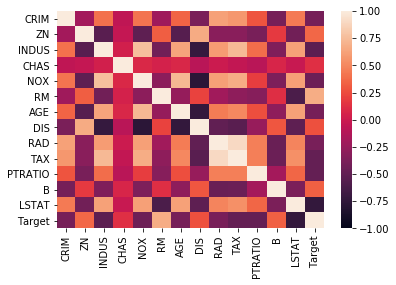

In [22]:
"""
Plotting the heat map of correlation matrix that represents the correlations between the columns of entire data.
"""
corr_matrix = np.corrcoef(training_data.T)
plt.figure()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, xticklabels=feature_labels,yticklabels=feature_labels)
plt.show()

By observing the color within the boxes, we can observe the features that are highly correlated (closer to 1 or -1), and lowly correlated (closer to 0) with target variable. We can say that while the features 'INDUS', 'RM', 'TAX', and  'LSTAT' obviously have high correlation with target variable, the features such as 'CHAS', 'DIS', and 'B' have low correlation.

## Task 2: Regression Tree


### 2.1 Feature Analysis
Let us make an introduction to the splitting criteria that we will use. The measure $RSS$ is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

Given that we have implemented the required functions that form the basis for the regression tree implementation, we can make our first observations about the insight that we have obtained by analyzing the dataset in `Task 1: Dataset`.

Below, you can observe the rss vs threshold values used in split for the features selected. The first feature, labeled as 'B', is lowly correlated with the target variable, while the second feature, labeled as 'LSTAT', is highly correlated.

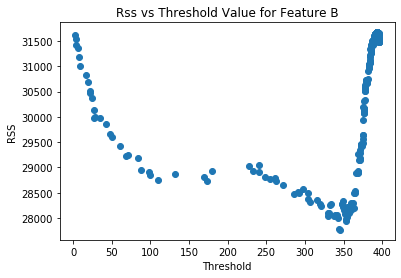

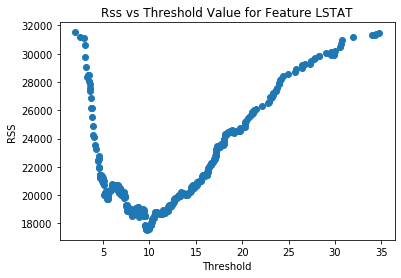

In [23]:
"""
Splitting the training data based on two predetermined features, then plotting the rss values by thresholds
which is the set of all values in terms of given feature.
"""
_ = find_split_by_feature(feature_index['B'],training_data,True,feature_labels)
_ = find_split_by_feature(feature_index['LSTAT'],training_data,True,feature_labels)

We observe that the highly correlated feature ('LSTAT') can yield rss values that is much lower that the lowly correlated feature ('B') can.
Second, we see that the range between rss values are much larger in highly correlated feature than lowly correlated feature.

NOTE:
* B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT: % lower status of the population

### 2.2 & 2.3 Implementing Regression Tree
The construction of regression tree is a recursive procedure that is stated below:
1. Initialize the root that has the entire data set as data.
2. Starting from the root, for each node, if the current depth level is not equal to maximum depth limit or the number samples are above the minimum size limit is:
    2.1 Split the current node by finding the best feature and threshold that yields the best rss value.
    2.2 Recursively split the left child.
    2.3 Recursively split the right child.
3. If the maximum depth level or minimum size limit is reached, convert the node into a leaf.

In `Auxiliary Resources` section, the required functions that form the basis for implementation are explained in detail. Please refer to their definitions in order to understand how they work and combine into together.


Let us testing our implementation by constructing a regression tree of depth 3. Below you can observe the initial r-squared score for the regression tree of depth 3 that we have constructed. We observe that the resulting r-squared scores are satisfactory.

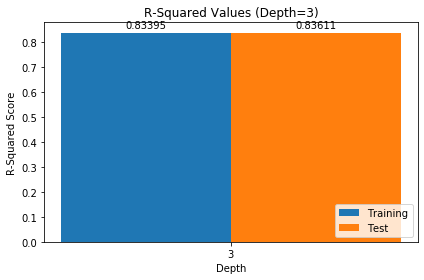

In [24]:
"""
Initialization and training of an initial regression tree for testing the implementation and r-squared values.
"""
initial_tree = train_tree(training_data,1,3)
yTrainPredicted_Init, yTest_Predicted_Init = predict(initial_tree,training_data) ,predict(initial_tree,test_data)
r2_plots([r2_score(yTrain,yTrainPredicted_Init)],[r2_score(yTest,yTest_Predicted_Init)],[3])

### 2.4 Visualization of Tree
<img src="tree.png">

## Task 3: Evaluation

### 3.1 Cross Validation
Now it is time to pick the best maximum depth for our dataset by using 5-fold cross validation. The general cross validation procedure works as follows:

1. Split the data into 5.
2. Iteratively construct a decision tree where one fold is used as the test data, and the rest is the training data.
3. Calculate the r-squared values for each regression trees.
4. Return the average of r-squared values and the standard deviation of r-squared values that are obtained by the trained regression trees.

In our case, we conduct cross validation for the maximum depth levels of [3,10] and report the mean of r-squared values and standard deviation for each depth, and finally pick the best one.

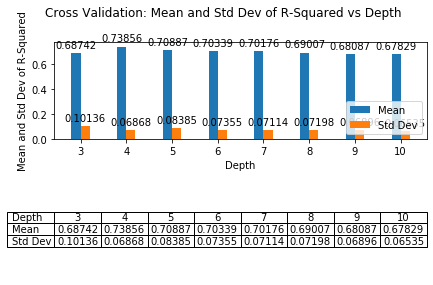

In [25]:
"""
Cross validation for the depth levels given below.
"""
depth_levels = [3,4,5,6,7,8,9,10]
b_depth,mean_r2,std_r2 = cross_validation(data=training_data,s=5,depths=depth_levels)
cross_validation_plot(depth_levels,mean_r2,std_r2)

### 3.2 Final Tree
Given that the cross validation algorithm has returned the best maximum depth for our dataset, we are ready to construct the final tree that we figure out to be the best. Below you can see the plot for r-squared score for the training and test data predictions of the final regression tree.

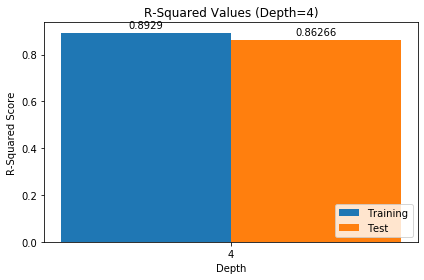

In [26]:
"""
The final regression tree that is constructed by the maximum depth value returned by cross validation.
"""
final_tree = train_tree(training_data,1,b_depth)
yTrain_Predicted_Final, yTest_Predicted_Final = predict(final_tree,training_data), predict(final_tree,test_data)
r2_plots([r2_score(yTrain,yTrain_Predicted_Final)],[r2_score(yTest,yTest_Predicted_Final)],[b_depth])

## Appendix

This section provides the extra work done that are not explicitly asked in the context of project.

### A.1
In section `3.1 Cross Validation`, the algorithm provides the best maximum depth that yields the best r-squared scores for test data. However, by further observations, I have experienced that since our dataset is relatively small and noisy, the training folds that are used in cross validation may not represent the entire data set characteristics successfully. 

Below, you can see the r-squared values for regression trees trained based on the maximum depth limit of [3,10]. However, we should still stick into the general procedures in machine learning applications by taking the best maximum depth as the one returned by cross validation.

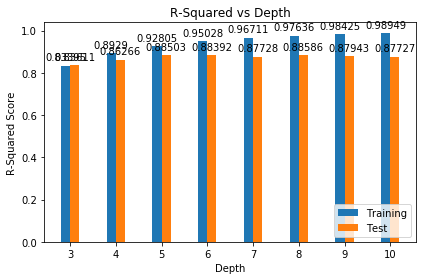

In [27]:
"""
R-squared analysis for the regression trees constructed by all depth values.
"""
r2_training, r2_test = list(),list()
for depth in depth_levels:
    tree = train_tree(training_data,1,depth)
    yTrain_Predicted = predict(tree, training_data)
    yTest_Predicted = predict(tree, test_data)
    r2_training.append(r2_score(yTrain,yTrain_Predicted))
    r2_test.append(r2_score(yTest, yTest_Predicted))
r2_plots(r2_training,r2_test,depth_levels)

# References

The reference for conceptual information:
* https://en.wikipedia.org/wiki/Decision_tree_learning

The reference which gave me the idea of implementing the tree by using a dictionary based representation of nodes:
* https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/ 